## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "map-proj-v3-classdirs"

2023-09-25 00:01:25.645860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 00:01:26.145167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-09-25 00:01:26.789600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-25 00:01:26.794183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-25 00:01:26.794336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Input pipeline
Using the Keras ImageDataGenerator, the dataset is split into train and validation in an 80/20 split. Class weights are calulated after loading the dataset.

In [3]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Set the image size and batch size
img_height = 224
img_width = 224
batch_size = 4

# Create ImageDataGenerator for data augmentation and loading the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # Normalize pixel values to [0, 1]
    validation_split=0.2 # set validation split
    # Add other data augmentation parameters as needed
)

# Load the dataset using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='validation')

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)


# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("")
print(class_weights_dict)
'''
#show some images
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))

for i in range(5):
    for j in range(10):

        # convert to unsigned integers for plotting
        image = next(train_generator)[0][0]

        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
        image = np.squeeze(image)

        # plot raw pixel data
        ax[i][j].imshow(image)
        ax[i][j].axis('off')
'''

Found 9578 images belonging to 7 classes.
Found 2392 images belonging to 7 classes.

{0: 0.9773469387755102, 1: 0.3490524781341108, 2: 1.5003132832080202, 3: 7.436335403726708, 4: 0.7340588595953402, 5: 3.600751879699248, 6: 1.4905073140367258}


"\n#show some images\nfig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))\n\nfor i in range(5):\n    for j in range(10):\n\n        # convert to unsigned integers for plotting\n        image = next(train_generator)[0][0]\n\n        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image\n        image = np.squeeze(image)\n\n        # plot raw pixel data\n        ax[i][j].imshow(image)\n        ax[i][j].axis('off')\n"

## Here, the dataset's class distribution is shown to verify the split

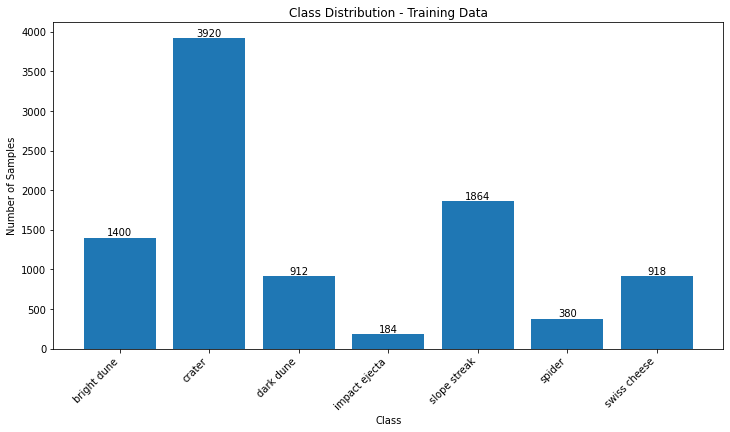

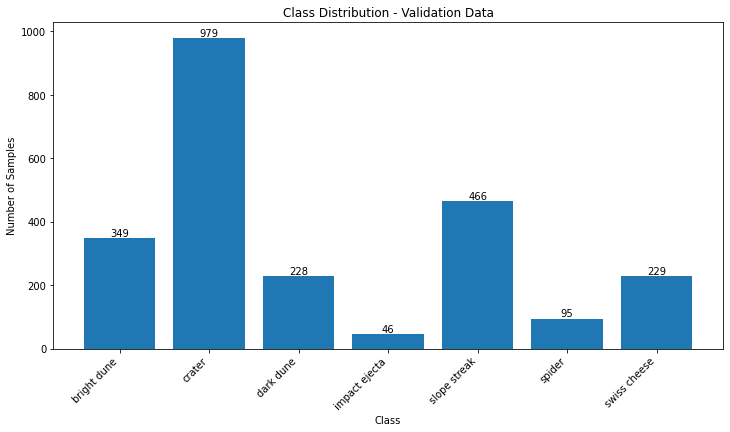

In [4]:
import matplotlib.pyplot as plt

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Count the number of samples for each class in the training data
train_class_counts = np.zeros(num_classes)
for _, labels in train_generator:
    for label in labels.argmax(axis=1):
        train_class_counts[label] += 1
    if train_generator.batch_index == 0:
        break

# Count the number of samples for each class in the validation data
validation_class_counts = np.zeros(num_classes)
for _, labels in validation_generator:
    for label in labels.argmax(axis=1):
        validation_class_counts[label] += 1
    if validation_generator.batch_index == 0:
        break

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the class distribution for training data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, train_class_counts)
plt.title("Class Distribution - Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(train_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the class distribution for validation data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, validation_class_counts)
plt.title("Class Distribution - Validation Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(validation_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

## Part 2/3: Building and Training

In [5]:
''' older alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

#old alexnet

'''

' older alexnet\nmodel = keras.models.Sequential([\n    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=\'relu\', input_shape=(img_height, img_width,3)),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=

In [6]:
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

# 5 convolutional layers
model = tf.keras.applications.ResNet152V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=7,
    classifier_activation="softmax",
)


2023-09-25 00:01:32.172157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-25 00:01:32.172331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-25 00:01:32.172440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
#see the layers!
model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

 tchNormalization)                                                                                
                                                                                                  
 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block4_out (Add)      (None, 28, 28, 512)          0         ['conv3_block3_out[0][0]',    
                                                                     'conv3_block4_3_conv[0][0]'] 
                                                                                                  
 conv3_block5_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block4_out[0][0]']    
 tchNormalization)                                                                                
                                                                                                  
 conv3_block5_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block5_preact_bn[0][0]
 Activation)                                                        ']                            
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv3_block7_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block7_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv3_block7_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block7_2_pad[0][0]']  
 D)                                                                                               
                                                                                                  
 conv3_block7_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block7_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv4_block1_preact_relu[0][
 D)                                                                 0]']                          
                                                                                                  
 conv4_block1_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_0_conv[0][0]', 
                                                                     'conv4_block1_3_conv[0][0]'] 
                                                                                                  
 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    
 tchNormal

                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block4_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block4_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_blo

 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_conv[0][0]'] 
                                                                                                  
 conv4_block7_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block6_out[0][0]']    
 tchNormalization)                                                                                
          

 conv4_block9_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block9_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block9_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv4_block9_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block9_2_pad[0][0]']  
 D)       

                                                                                                  
 conv4_block11_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block11_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block11_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block10_out[0][0]',   
                                                                     'conv4_block11_3_conv[0][0]']
                                                                                                  
 conv4_block12_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block11_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block14_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block14_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block14_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block14_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block14_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block14_2_pad[0][0]'] 
 2D)                                                                                              
          

 conv4_block16_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block16_2_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block15_out[0][0]',   
                                                                     'conv4_block16_3_conv[0][0]']
                                                                                                  
 conv4_block17_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block16_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block17_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block17_preact_bn[0][0
 (Activati

                                                                                                  
 conv4_block19_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block19_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block19_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block19_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block19_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block21_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block20_out[0][0]',   
                                                                     'conv4_block21_3_conv[0][0]']
                                                                                                  
 conv4_block22_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block21_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block22_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block22_preact_bn[0][0
 (Activation)                                                       ]']                           
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block24_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block24_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block24_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block24_2_conv[0][0]']
 ormalizat

                                                                                                  
 conv4_block26_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block25_out[0][0]',   
                                                                     'conv4_block26_3_conv[0][0]']
                                                                                                  
 conv4_block27_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block26_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block27_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block27_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block29_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block29_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block29_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block29_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block29_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block29_2_conv[0][0]']
 ormalization)                                                                                    
          

 conv4_block31_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block30_out[0][0]',   
                                                                     'conv4_block31_3_conv[0][0]']
                                                                                                  
 conv4_block32_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block31_out[0][0]']   
 atchNormalization)                                                                               
                                                                                                  
 conv4_block32_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block32_preact_bn[0][0
 (Activation)                                                       ]']                           
                                                                                                  
 conv4_block32_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block32_preact_relu[0]
 2D)      

                                                                                                  
 conv4_block34_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block34_1_relu[0][0]']
 adding2D)                                                                                        
                                                                                                  
 conv4_block34_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block34_2_pad[0][0]'] 
 2D)                                                                                              
                                                                                                  
 conv4_block34_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block34_2_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block36_out (Add)     (None, 7, 7, 1024)           0         ['max_pooling2d_2[0][0]',     
                                                                     'conv4_block36_3_conv[0][0]']
                                                                                                  
 conv5_block1_preact_bn (Ba  (None, 7, 7, 1024)           4096      ['conv4_block36_out[0][0]']   
 tchNormalization)                                                                                
                                                                                                  
 conv5_block1_preact_relu (  (None, 7, 7, 1024)           0         ['conv5_block1_preact_bn[0][0]
 Activation)                                                        ']                            
          

 conv5_block3_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block3_1_relu[0][0]'] 
 dding2D)                                                                                         
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block3_2_pad[0][0]']  
 D)       

In [9]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [10]:
#train the model, time to cook!


#set up tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs=5

history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [tensorboard_callback],
)

Epoch 1/5


2023-09-25 00:01:55.147331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-09-25 00:01:56.428479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-25 00:01:56.430283: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f96a7e2b400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 00:01:56.430298: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-09-25 00:01:56.433229: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 00:01:56.515027: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

2394/2394 [==============================] - 425s 155ms/step - loss: 1.1747 - accuracy: 0.5781 - val_loss: 2.0583 - val_accuracy: 0.5723
Epoch 2/5
2394/2394 [==============================] - 418s 174ms/step - loss: 0.8450 - accuracy: 0.7090 - val_loss: 3.1517 - val_accuracy: 0.2701
Epoch 3/5
2394/2394 [==============================] - 426s 178ms/step - loss: 0.7169 - accuracy: 0.7578 - val_loss: 1.3403 - val_accuracy: 0.6334
Epoch 4/5
2394/2394 [==============================] - 419s 175ms/step - loss: 0.6055 - accuracy: 0.7949 - val_loss: 2.7205 - val_accuracy: 0.2914
Epoch 5/5
2394/2394 [==============================] - 423s 177ms/step - loss: 0.4778 - accuracy: 0.8375 - val_loss: 1.8261 - val_accuracy: 0.6793


# 

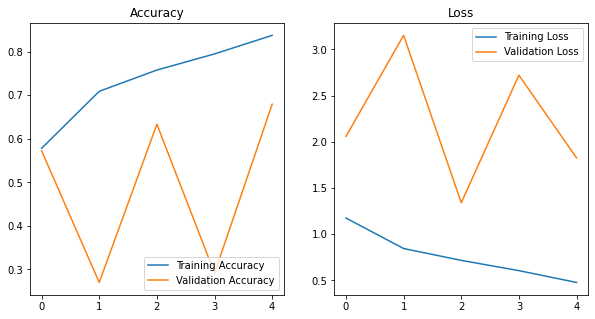

In [11]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [12]:
# evaluate the accuracy
score = model.evaluate(validation_generator, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

Validation Loss: 1.8260939121246338
Validation Accuracy: 0.679347813129425
Min Validation Loss: 1.3402912616729736
Max Validation Accuracy: 0.679347813129425


In [13]:
# generate the confusion matrix

# predict on the validation dataset
validation_predictions = model.predict(validation_generator)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(validation_generator.classes, predicted_labels)

598/598 [==============================] - 23s 36ms/step


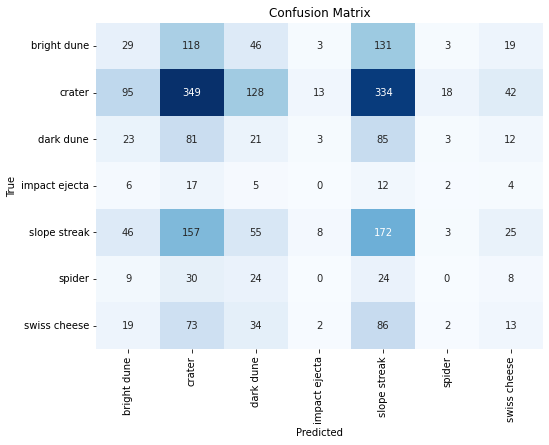

In [14]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Calculate precision and recall for each class
precision_per_class = precision_score(validation_generator.classes, predicted_labels, average=None)
recall_per_class = recall_score(validation_generator.classes, predicted_labels, average=None)

# Display precision and recall for each class
for i, class_label in enumerate(class_labels):
    print(f"Class: {class_label}")
    print(f"Precision: {precision_per_class[i]:.2f}")
    print(f"Recall: {recall_per_class[i]:.2f}")
    print("------------")

# Calculate and display overall precision and recall
overall_precision = precision_score(validation_generator.classes, predicted_labels, average='weighted')
overall_recall = recall_score(validation_generator.classes, predicted_labels, average='weighted')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)

# Generate a classification report
classification_rep = classification_report(validation_generator.classes, predicted_labels, target_names=class_labels)
print("Classification Report:\n", classification_rep)

Class: bright dune
Precision: 0.13
Recall: 0.08
------------
Class: crater
Precision: 0.42
Recall: 0.36
------------
Class: dark dune
Precision: 0.07
Recall: 0.09
------------
Class: impact ejecta
Precision: 0.00
Recall: 0.00
------------
Class: slope streak
Precision: 0.20
Recall: 0.37
------------
Class: spider
Precision: 0.00
Recall: 0.00
------------
Class: swiss cheese
Precision: 0.11
Recall: 0.06
------------
Overall Precision: 0.24799321531274088
Overall Recall: 0.24414715719063546
Classification Report:
                precision    recall  f1-score   support

  bright dune       0.13      0.08      0.10       349
       crater       0.42      0.36      0.39       979
    dark dune       0.07      0.09      0.08       228
impact ejecta       0.00      0.00      0.00        46
 slope streak       0.20      0.37      0.26       466
       spider       0.00      0.00      0.00        95
 swiss cheese       0.11      0.06      0.07       229

     accuracy                           